In [4]:
# Import Dependancies and Load Data

#Import Dependancies
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load Suburb data
LANDING_DATA_DIR = "../../data/landing"
RAW_DATA_DIR = "../../data/raw"
CURATED_DATA_DIR = "../../data/curated"
PLOT_DATA_DIR = "../../plots/"

liveability_features = \
    pd.read_csv(f"{CURATED_DATA_DIR}/liveability_features.csv")
liveability_features.head()

,suburb,schools_count,hospital_count,open_space_count,trams_count,public_transport_stops_count,bus_stops_count,train_stops_count,crime_count
0,abbeyard,0.0,0.0,0.0,NaN,0,0,0,7.0
1,abbotsford,2.0,0.0,48.0,5.0,21,14,2,516.0
2,aberfeldie,4.0,0.0,13.0,NaN,20,20,0,269.0
3,aberfeldy,0.0,0.0,0.0,NaN,0,0,0,6.0
4,acheron,0.0,0.0,0.0,NaN,2,2,0,33.0


In [5]:

# Select the numerical columns for normalization
numerical_columns = ['schools_count', 'hospital_count', 
                     'open_space_count', 'trams_count', 
                     'public_transport_stops_count', 'bus_stops_count', 
                     'train_stops_count', 'crime_count']

# Normalize the data using Min-Max scaling
scaler = MinMaxScaler()
standard_df = liveability_features.copy()  
standard_df[numerical_columns] = \
    scaler.fit_transform(standard_df[numerical_columns])

# Define weights for each feature
weights = {
    'schools_count': 0.15,
    'hospital_count': 0.15,
    'open_space_count': 0.3,
    'trams_count': 0.2,
    'public_transport_stops_count': 0,
    'bus_stops_count': 0.15,
    'train_stops_count': 0.3,
    'crime_count': -0.25  
    #You may assign a negative weight if you want to penalize high crime counts
}

# Calculate the liveability score for each suburb
standard_df['liveability_Score'] = \
    standard_df.apply(lambda row: 
                      sum(weights[feature] * row[feature] 
                          for feature in numerical_columns), axis=1)

# Initialize a MinMaxScaler for the liveability scores
liveability_scaler = MinMaxScaler(feature_range=(0, 100))

# Reshape the 'liveability_Score' column for scaling
liveability_values = standard_df['liveability_Score'].values.reshape(-1, 1)

# Fit and transform the liveability scores
scaled_liveability_scores = liveability_scaler.fit_transform(liveability_values)

# Assign the scaled liveability scores back to the DataFrame
standard_df['liveability_Score'] = scaled_liveability_scores

# Rank suburbs by liveability score
ranked_suburbs = standard_df.sort_values(by='liveability_Score',
                                          ascending=False)

# Save to curated data folder 
filename = "liveability_ranked.csv"
ranked_suburbs.to_csv(f"{CURATED_DATA_DIR}/{filename}", index=False)


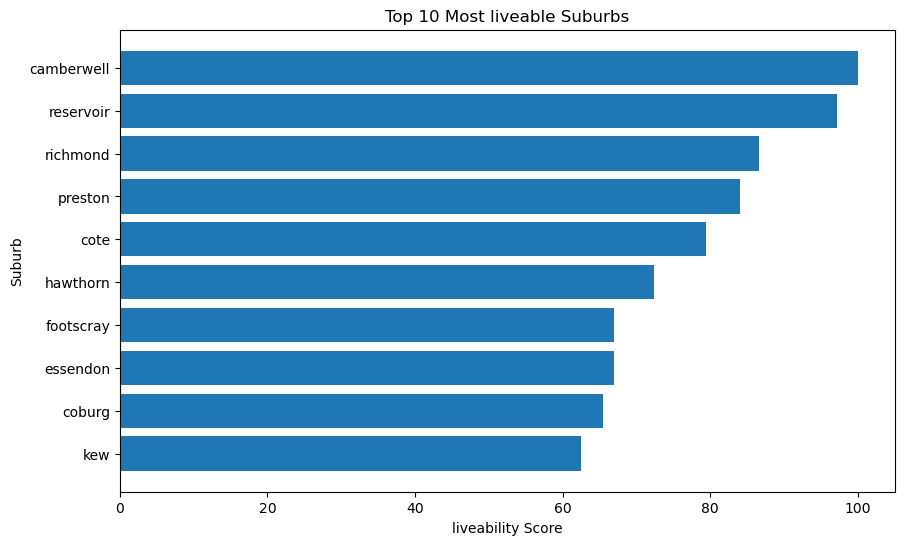

In [6]:
import matplotlib.pyplot as plt

N = 10  # Number of suburbs to display
top_suburbs = ranked_suburbs.head(N)

plt.figure(figsize=(10, 6))
plt.barh(top_suburbs['suburb'], top_suburbs['liveability_Score'])
plt.xlabel('liveability Score')
plt.ylabel('Suburb')
plt.title(f'Top {N} Most liveable Suburbs')
plt.gca().invert_yaxis()  # Invert the y-axis to show the highest score 

# Save the plot
plt.savefig(f'{PLOT_DATA_DIR}/top_10_liveable_suburbs.png')


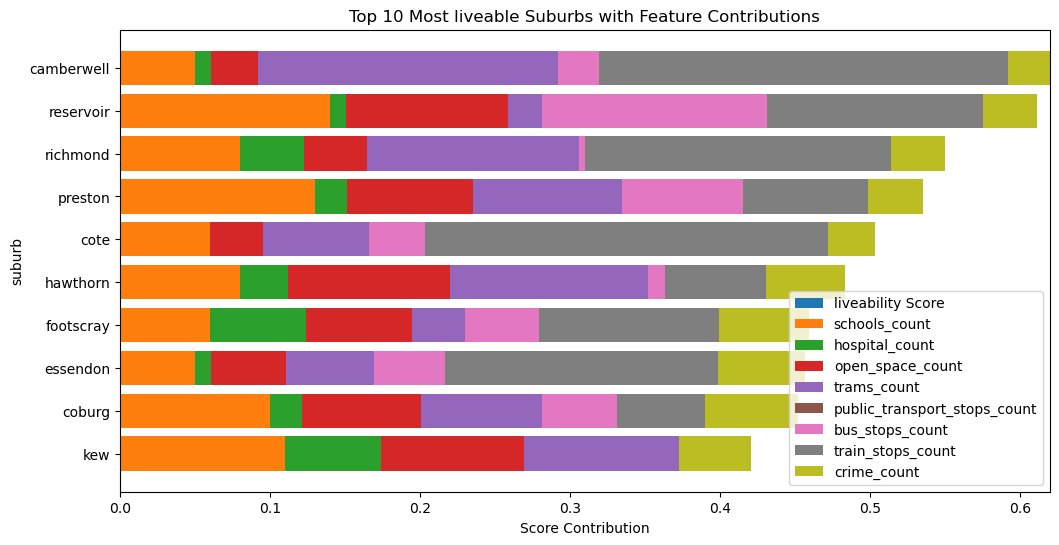

In [8]:
feature_contributions = top_suburbs[numerical_columns].mul(weights)
plt.figure(figsize=(12, 6))
plt.barh(top_suburbs['suburb'], feature_contributions.T.sum(),
          label='liveability Score')
bottom = 0

for feature in numerical_columns:
    plt.barh(top_suburbs['suburb'], feature_contributions[feature], 
             label=feature, left=bottom)
    bottom += feature_contributions[feature]

plt.xlabel('Score Contribution')
plt.ylabel('suburb')
plt.title(f'Top {N} Most liveable Suburbs with Feature Contributions')
plt.gca().invert_yaxis()
plt.legend()

# Save the plot
plt.savefig(f'{PLOT_DATA_DIR}/top_10_liveable_suburbs_features.png')
